# Image Filteration (2)

## Filteration in Frequency Domain



### Gaussian Filteration

In [1]:
import numpy as np
from scipy import fftpack, signal, stats
import matplotlib.pyplot as plt

In [2]:
#?signal.gaussian

#### Gaussian Kernel

In [3]:
def gaussian_kernel1d(kernlen=7, std=1.5):
    """Returns a 1D Gaussian window."""
    kernel1d = signal.gaussian(kernlen, std=std)
    kernel1d = kernel1d.reshape(kernlen, 1)
    return kernel1d / kernel1d.sum()

def gaussian_kernel2d(kernlen=7, std=1.5):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = gaussian_kernel1d(kernlen,std)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def get_img_stats(img):
    _,mnmx, mn, var,_,_ = stats.describe(img.ravel())
    return '%.4f' % mnmx[0],  '%.4f' % mnmx[1], '%.4f' % mn,  '%.4f' % var

from tabulate import tabulate

def print_imgs_stats( names_imgs ):
    rows = []
    headers = ["Name", "Shape", "min", "max", "mean", "variance"]
    for name,img in names_imgs:
        rows.append([name, img.shape, *get_img_stats(img)])
    
    return tabulate(rows, headers, tablefmt="fancy_grid")

def print_img_stats(name,img):
    mn,mx, mean, var = get_img_stats(img)
    print("Img ({}): minmax =({:2f},{:2f}), mean={:2f}, var={:2f}".format(name,mn,mx,mean,var))


In [4]:
#####################################################################
# The original image
#####################################################################

# read image
x_img = plt.imread('images/some-pigeon.jpg')
kernel = gaussian_kernel2d(kernlen=15, std=3)

# We use :func:`scipy.signal.fftpack.fft2` to have a 2D FFT
x_img_ft = fftpack.fft2(x_img, axes=(0, 1))
# Padded fourier transform, with the same shape as the image
kernel_ft = fftpack.fft2(kernel, shape=x_img.shape[:2], axes=(0, 1))

# the 'newaxis' is to match to color direction (and broadcast)
y_img_ft = kernel_ft[:, :, np.newaxis] * x_img_ft
y_img = fftpack.ifft2(y_img_ft, axes=(0, 1)).real
# clip values to range
y_img = y_img.astype(x_img.dtype)


# Let's define a function for later use
def ft_filter(x, kernel):
    x_ft = fftpack.fft2(x, axes=(0, 1))
    kernel_ft = fftpack.fft2(kernel, shape=x.shape[:2], axes=(0, 1))
    y_ft = kernel_ft[:, :, np.newaxis] * x_ft
    y = fftpack.ifft2(y_ft, axes=(0, 1)).real
    if np.issubdtype(x.dtype, np.integer):
        y = y + 0.5
    y = y.astype(x.dtype)
    return y

In [5]:
# tabulate data
table = print_imgs_stats([ ("x_img",x_img),
                          ("kernel", kernel),
                          ("y_img", y_img),
                          ("x_img_ft", abs(x_img_ft)),
                          ("log10(x_img_ft)", np.log10(abs(x_img_ft))),
                          ("kernel_ft", abs(kernel_ft)),
                          ("dot_ft", abs(y_img_ft))])

# output
print(table)

╒═════════════════╤════════════════╤═════════╤═══════════════╤═══════════╤════════════════╕
│ Name            │ Shape          │     min │           max │      mean │       variance │
╞═════════════════╪════════════════╪═════════╪═══════════════╪═══════════╪════════════════╡
│ x_img           │ (768, 1024, 3) │  3      │ 255           │  178.218  │ 2494.8         │
├─────────────────┼────────────────┼─────────┼───────────────┼───────────┼────────────────┤
│ kernel          │ (15, 15)       │  0.0001 │   0.0181      │    0.0044 │    0           │
├─────────────────┼────────────────┼─────────┼───────────────┼───────────┼────────────────┤
│ y_img           │ (768, 1024, 3) │ 12      │ 254           │  177.719  │ 2283.82        │
├─────────────────┼────────────────┼─────────┼───────────────┼───────────┼────────────────┤
│ x_img_ft        │ (768, 1024, 3) │  7.8956 │   1.40858e+08 │ 9155.73   │    2.68564e+10 │
├─────────────────┼────────────────┼─────────┼───────────────┼───────────┼──────

<Figure size 432x288 with 0 Axes>

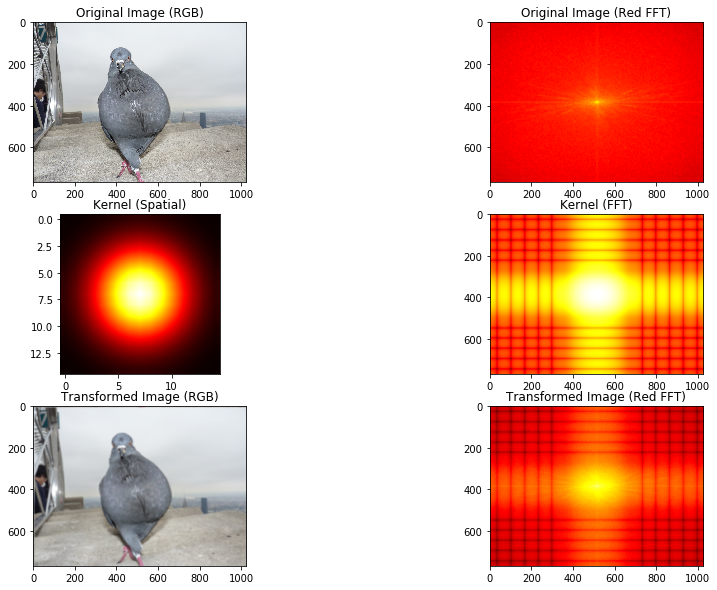

In [6]:
plt.set_cmap('seismic')
import matplotlib.cm as cm

fig, ax = plt.subplots(3,2,figsize = (15, 10))

ax[0,0].set_title('Original Image (RGB)')
ax[0,0].imshow(x_img)

ax[0,1].set_title('Original Image (Red FFT)')
ax[0,1].imshow(np.log10(abs(fftpack.fftshift(x_img_ft[:,:,0]))),  cmap=cm.hot,interpolation='bilinear')


ax[1,0].set_title('Kernel (Spatial)')
ax[1,0].imshow(kernel,interpolation='bilinear', cmap=cm.hot,)

ax[1,1].set_title('Kernel (FFT)')
ax[1,1].imshow(np.log10(abs(fftpack.fftshift(kernel_ft))), cmap=cm.hot,interpolation='bilinear')

ax[2,0].set_title('Transformed Image (RGB)')
ax[2,0].imshow(y_img)

ax[2,1].set_title('Transformed Image (Red FFT)')
ax[2,1].imshow(np.log10(abs(fftpack.fftshift(y_img_ft[:,:,0]))), cmap=cm.hot,interpolation='bilinear')


plt.show()

#### Spatial Filtering vs Frequency Filtering (plust Seperable Filtering)

In [44]:
from scipy.signal import convolve2d,correlate2d
def conv_filter(x, kernel):    
    y_conv2d = np.empty(x.shape)
    for channel in range(x.shape[2]):
        y_conv2d[:,:,channel] = correlate2d(x[:,:,channel],kernel,'same')
    if np.issubdtype(x.dtype, np.integer):
        y_conv2d = y_conv2d + 0.5
    return y_conv2d.astype(x.dtype)


x = plt.imread('images/Henry_Moore_Yorkshire_Sculpture_Park_0330.jpg')
kernel = gaussian_kernel2d(kernlen=10, std=5)

y_conv2d = conv_filter(x,kernel)
y_fft2d = ft_filter(x,kernel)

kernel1d = gaussian_kernel1d(kernlen=10, std=5)
y_sep2d = conv_filter( conv_filter( x , kernel1d ), kernel1d.T )

t = print_imgs_stats([("y_conv2d",y_conv2d),
                      ("y_sep2d",y_sep2d),
                      ("y_fft2d", y_fft2d)])
print(t)

╒══════════╤════════════════╤═══════╤═══════╤═════════╤════════════╕
│ Name     │ Shape          │   min │   max │    mean │   variance │
╞══════════╪════════════════╪═══════╪═══════╪═════════╪════════════╡
│ y_conv2d │ (768, 1024, 3) │     1 │   255 │ 148.003 │    7532.38 │
├──────────┼────────────────┼───────┼───────┼─────────┼────────────┤
│ y_sep2d  │ (768, 1024, 3) │     1 │   255 │ 148.004 │    7532.29 │
├──────────┼────────────────┼───────┼───────┼─────────┼────────────┤
│ y_fft2d  │ (768, 1024, 3) │     2 │   255 │ 148.916 │    7508.81 │
╘══════════╧════════════════╧═══════╧═══════╧═════════╧════════════╛


In [45]:
def distance(x1, x2):
    return np.sum((x1-x2)**2) / np.size(x1)

d1 = distance(y_conv2d,y_sep2d)
d2 = distance(y_fft2d,y_sep2d)


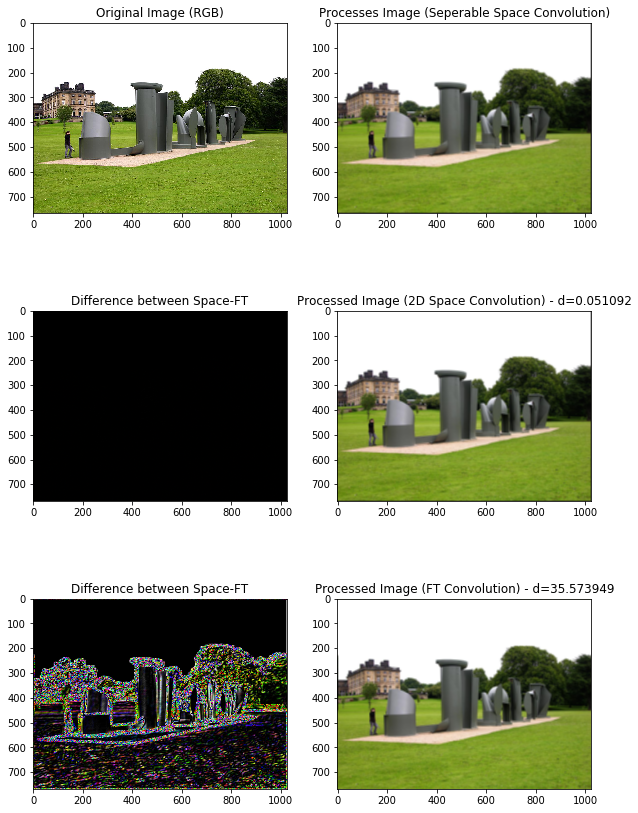

In [46]:
fig, ax = plt.subplots(3,2,figsize = (10, 15))

ax[0,0].set_title('Original Image (RGB)')
ax[0,0].imshow(x)

ax[0,1].set_title('Processes Image (Seperable Space Convolution)')
ax[0,1].imshow(y_sep2d)

ax[1,1].set_title('Processed Image (2D Space Convolution) - d={:4f}'.format(d1))
ax[1,1].imshow(y_conv2d)


ax[1,0].set_title('Difference between Space-FT')
ax[1,0].imshow((y_conv2d-y_sep2d)**2)


ax[2,1].set_title('Processed Image (FT Convolution) - d={:4f}'.format(d2))
ax[2,1].imshow(y_fft2d)


ax[2,0].set_title('Difference between Space-FT')
ax[2,0].imshow((y_fft2d-y_sep2d)**2)

plt.show()

##### Computational Time

In [48]:
import time

rows=[]
header = ["Kernel Size", "Sep. Conv (s)", "2D Conv (s)", "FFT Conv (s)"]
for kernel_len in range(3,51,2):
    kernel2d = gaussian_kernel2d(kernlen=kernel_len, std=5)
    kernel1d = gaussian_kernel1d(kernlen=kernel_len, std=5)
    kernel1dT= kernel1d.T
    
    t = time.process_time()
    y_conv2d = conv_filter(x,kernel)
    conv2d_time = '%.3f' % ((time.process_time() - t))
     
    t = time.process_time()
    y_fft2d = ft_filter(x,kernel)
    fft2d_time = '%.3f' % ((time.process_time() - t))

    t = time.process_time()
    y_sep2d = conv_filter( conv_filter( x , kernel1d ), kernel1dT )
    sep2d_time = '%.3f' % ((time.process_time() - t))

    rows.append(["{}x{}".format(kernel_len,kernel_len), sep2d_time, conv2d_time, fft2d_time])
t = tabulate(rows, header, tablefmt="fancy_grid")
print(t)

╒═══════════════╤═════════════════╤═══════════════╤════════════════╕
│ Kernel Size   │   Sep. Conv (s) │   2D Conv (s) │   FFT Conv (s) │
╞═══════════════╪═════════════════╪═══════════════╪════════════════╡
│ 3x3           │           0.175 │         0.611 │          0.389 │
├───────────────┼─────────────────┼───────────────┼────────────────┤
│ 5x5           │           0.223 │         0.941 │          0.38  │
├───────────────┼─────────────────┼───────────────┼────────────────┤
│ 7x7           │           0.276 │         0.762 │          0.387 │
├───────────────┼─────────────────┼───────────────┼────────────────┤
│ 9x9           │           0.332 │         0.764 │          0.377 │
├───────────────┼─────────────────┼───────────────┼────────────────┤
│ 11x11         │           0.347 │         0.763 │          0.378 │
├───────────────┼─────────────────┼───────────────┼────────────────┤
│ 13x13         │           0.416 │         0.761 │          0.387 │
├───────────────┼─────────────────